In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-03 14:16:42.536053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-25(iii) dataset @2.4GHz

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/2.4GHz/Device-25(iii)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[0.015625 +0.015625j  0.03125  -0.015625j  0.0078125+0.0078125j ...
 0.03125  +0.0078125j 0.03125  +0.015625j  0.       -0.03125j  ]
2048
83681
(2048, 83681)
[0.02104321 0.01540871 0.00928071 ... 0.00566445 0.00925158 0.01326612]
0
(10000, 2048)
(10000,)
[ 0.03125  +0.015625j   0.015625 +0.j         0.015625 +0.03125j   ...
  0.0234375-0.0078125j  0.015625 +0.015625j  -0.0078125+0.0234375j]
2048
88285
(2048, 88285)
[0.02849545 0.02305507 0.02355783 ... 0.02137687 0.02124649 0.02164258]
1
(20000, 2048)
(20000,)
[-0.0078125+0.0078125j -0.03125  +0.0078125j  0.0546875+0.015625j  ...
  0.0234375+0.j         0.0234375-0.0234375j  0.       -0.0078125j]
2048
79801
(2048, 79801)
[0.02398571 0.01750634 0.00994911 ... 0.00940471 0.00810553 0.01739133]
2
(30000, 2048)
(30000,)
[ 0.03125  +0.015625j   0.0234375-0.0078125j  0.03125  -0.015625j  ...
 -0.1328125-0.3359375j  0.28125  -0.2265625j  0.2890625+0.25j     ]
2048
86311
(2048, 86311)
[0.04492214 0.05376678 0.05611761 ... 0.03631224 0.03270427

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-25(iii) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

2023-04-03 14:22:45.888210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 16s 6ms/step - loss: 5.8313 - accuracy: 0.4606
test loss, test acc: [5.831313133239746, 0.46057501435279846]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[1 7 7 ... 7 7 7]
1
[[7452    1    0    0    0    0   18 2529]
 [   0 9583  163   19  113   29   12   81]
 [8861    0    0    0    0    0  815  324]
 [   1   85    0 9897   15    0    1    1]
 [   1 4105 2725    3   18    2    9 3137]
 [   0  345 9067    5  488   20   17   58]
 [   0 4014    0 5869    2    3   96   16]
 [   1    8  192    0    3    9    7 9780]]
              precision    recall  f1-score   support

           0       0.46      0.75      0.57     10000
           1       0.53      0.96      0.68     10000
           2       0.00      0.00      0.00     10000
           3       0.63      0.99      0.77     10000
           4       0.03      0.00      0.00     10000
           5       0.32      0.00      0.00     10000
           6       0.10      0.01      0.02     10000
           7       0.61      0.98      0.75     10000

    accuracy                           0.46     80000
   macro avg       0.33      0.46  

Test Accuracy:0.460575


Text(0.5, 1.0, 'Accuracy:0.461')

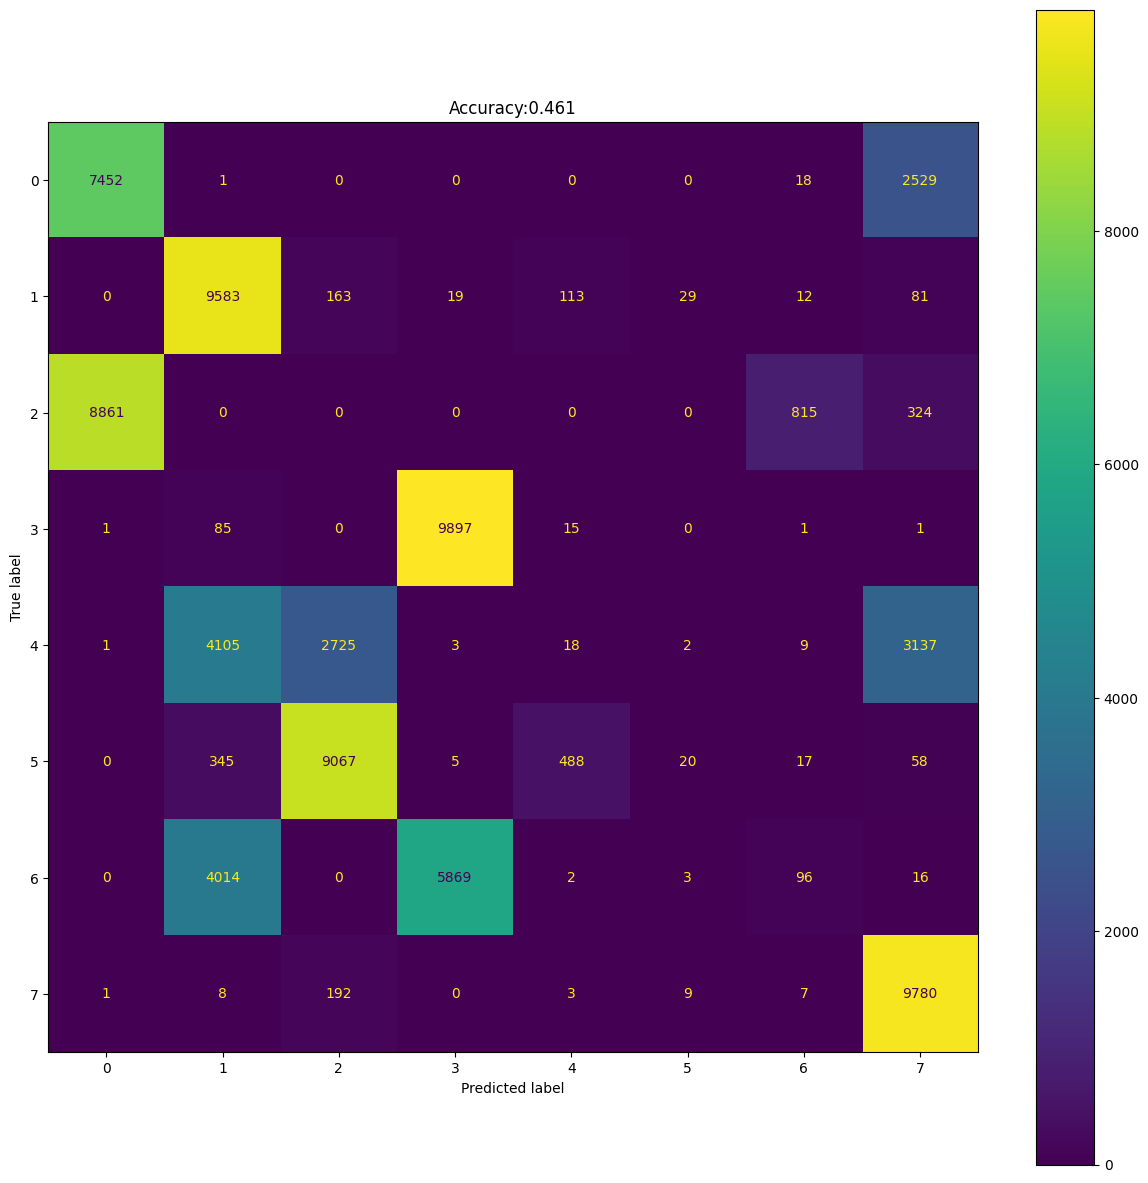

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning @2.4GHz

Nordic Device-25(i) model to Nordic Device-25(iii) dataset 

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.1628 - accuracy: 0.6485
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4389 - accuracy: 0.8554
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.3691 - accuracy: 0.9016
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.3452 - accuracy: 0.9117
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3312 - accuracy: 0.9169
Epoch 6/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.3210 - accuracy: 0.9204
Epoch 7/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.3126 - accuracy: 0.9229
Epoch 8/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.3057 - accuracy: 0.9252
Epoch 9/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.2994 - accuracy: 0.9271
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - l

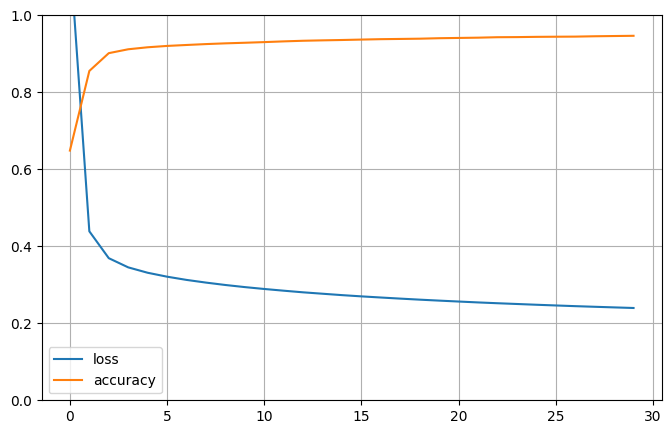

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2386 - accuracy: 0.9470
test loss, test acc: [0.23858511447906494, 0.9469624757766724]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[1 7 7 ... 7 7 7]
1
[[8947    1  996    0    0    0    1   55]
 [   0 9422    3   11  175  300   58   31]
 [1031    0 8929    0    1    0    3   36]
 [   0   46    1 9876    1    6   69    1]
 [   1  351    8    2 9305  217   17   99]
 [   0  235   10   11   53 9629   15   47]
 [   0  106    9   26    8    3 9836   12]
 [   7    8   11    0   70   88    3 9813]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     10000
           1       0.93      0.94      0.93     10000
           2       0.90      0.89      0.89     10000
           3       0.99      0.99      0.99     10000
           4       0.97      0.93      0.95     10000
           5       0.94      0.96      0.95     10000
           6       0.98      0.98      0.98     10000
           7       0.97      0.98      0.98     10000

    accuracy                           0.95     80000
   macro avg       0.95      0.95  

Test Accuracy:0.9469625


Text(0.5, 1.0, 'Accuracy:0.947')

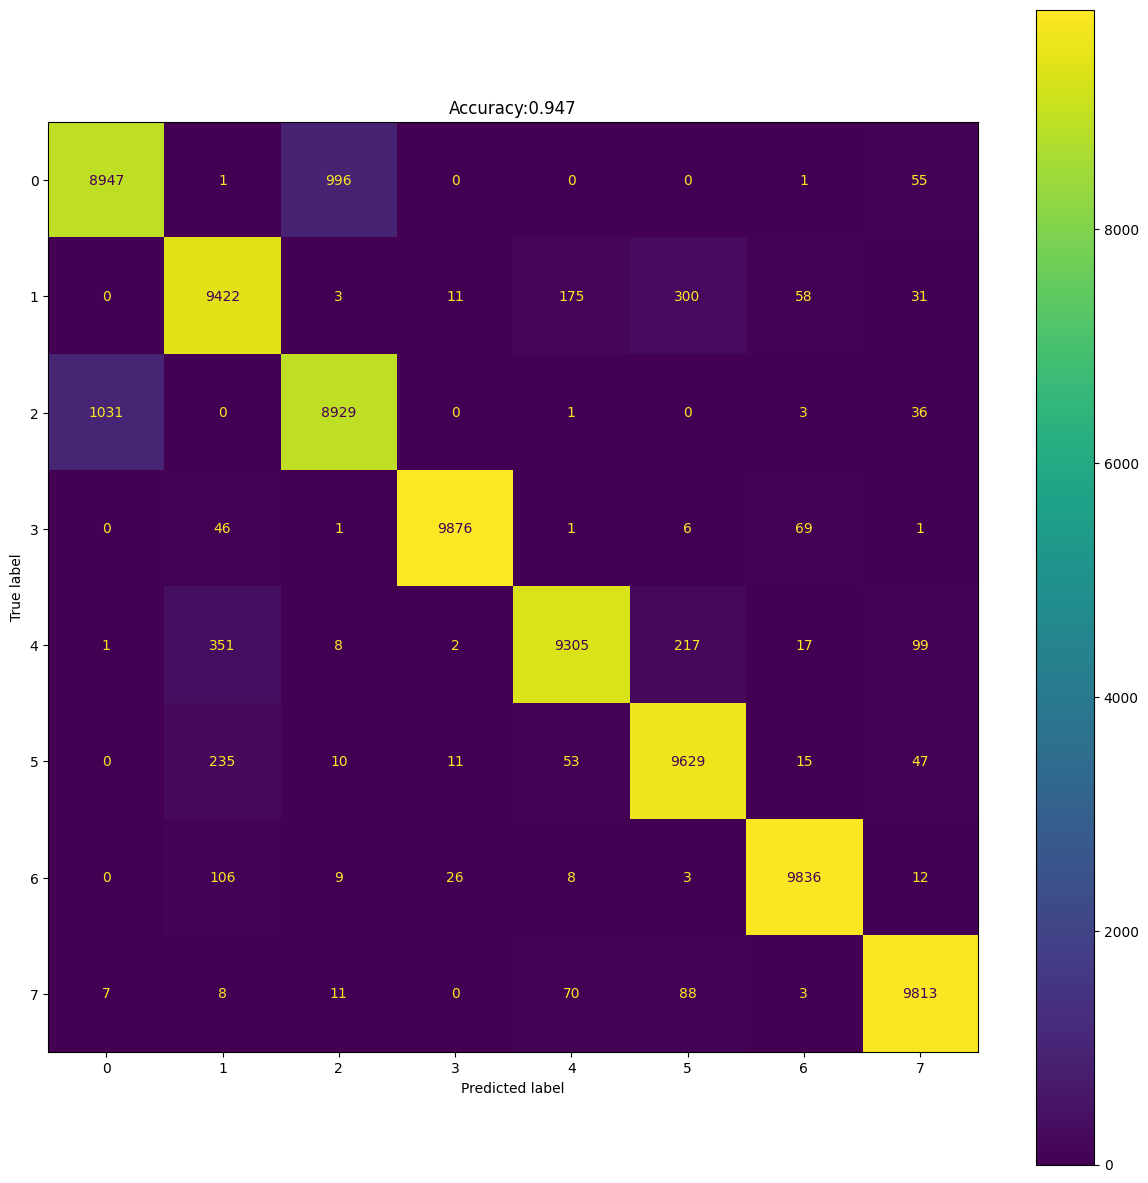

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(ii) model to Nordic Device-25(iii) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 6.0934 - accuracy: 0.5052
test loss, test acc: [6.093386173248291, 0.5052000284194946]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[3 1 1 ... 2 2 1]
3
[[8966   67    1    1  962    1    0    2]
 [   1 9667    1  149    2  100   80    0]
 [9670  194    3    5  119    0    1    8]
 [   0    5    0 9742    0    3  249    1]
 [   1 6213    0  174    0 1205 2407    0]
 [   0  308  474    6    6 9154   52    0]
 [   1  559    2 6525    1   23 2884    5]
 [   3 4588 5345    2   20   41    1    0]]
              precision    recall  f1-score   support

           0       0.48      0.90      0.63     10000
           1       0.45      0.97      0.61     10000
           2       0.00      0.00      0.00     10000
           3       0.59      0.97      0.73     10000
           4       0.00      0.00      0.00     10000
           5       0.87      0.92      0.89     10000
           6       0.51      0.29      0.37     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.51     80000
   macro avg       0.36      0.51  

Test Accuracy:0.5052


Text(0.5, 1.0, 'Accuracy:0.505')

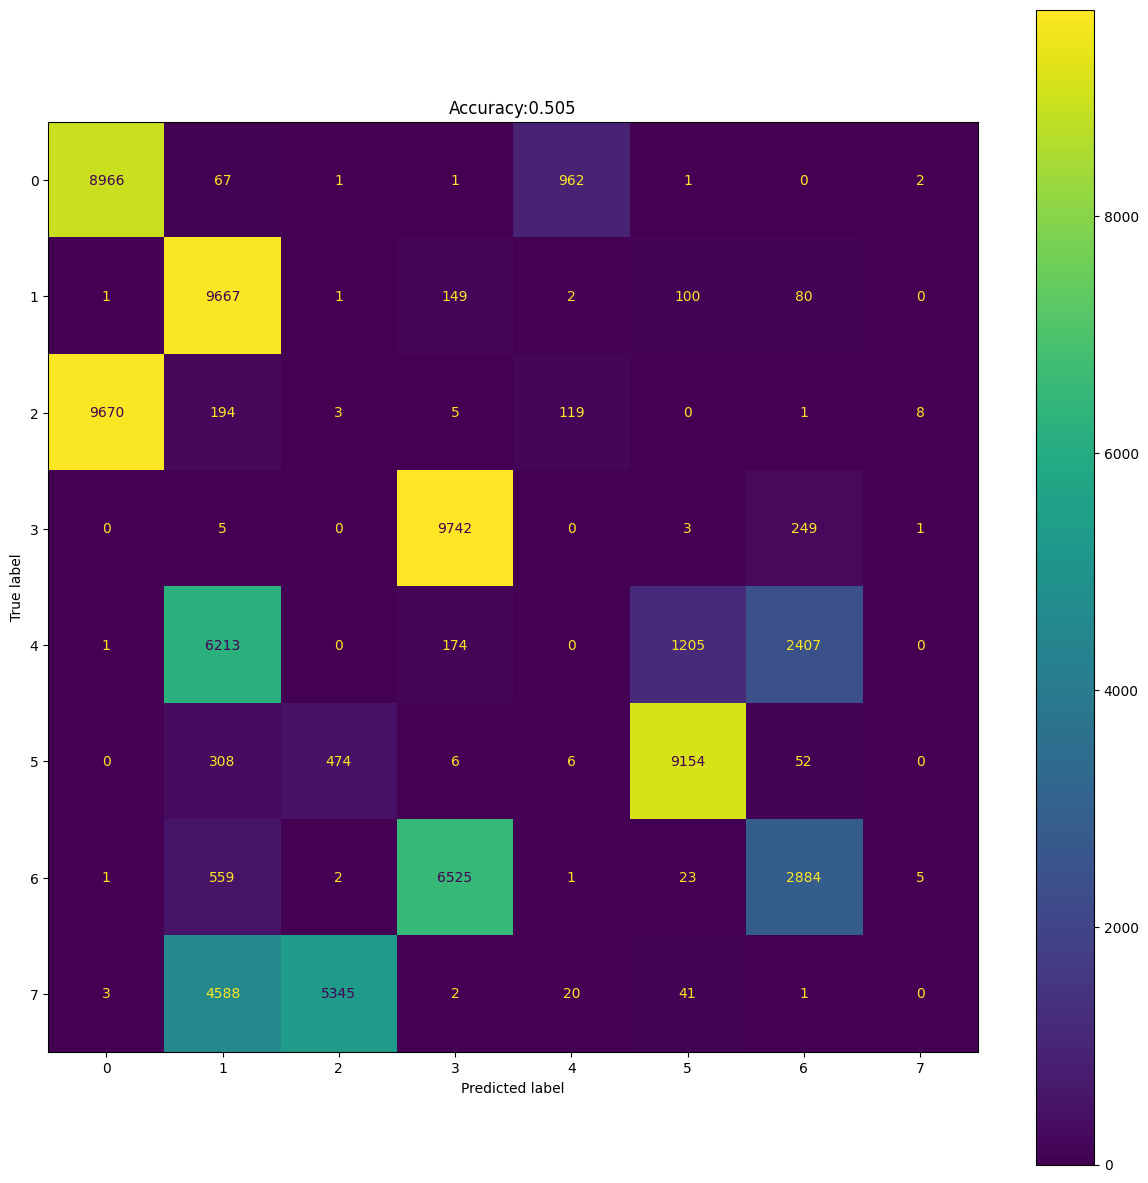

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning @2.4GHz

Nordic Device-25(ii) model to Nordic Device-25(iii) dataset 

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [20]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.5162 - accuracy: 0.6342
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5328 - accuracy: 0.8465
Epoch 3/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.4565 - accuracy: 0.8759
Epoch 4/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4187 - accuracy: 0.8890
Epoch 5/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.3954 - accuracy: 0.8950
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3789 - accuracy: 0.8995
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3664 - accuracy: 0.9022
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3560 - accuracy: 0.9053
Epoch 9/30
2500/2500 [==============================] - 14s 6ms/step - loss: 0.3471 - accuracy: 0.9081
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

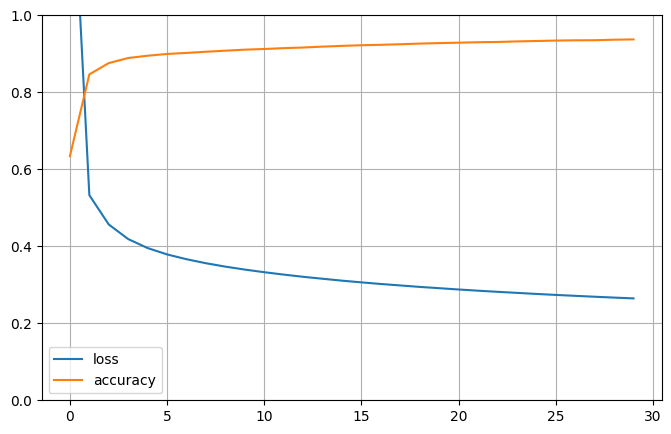

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [23]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.2634 - accuracy: 0.9372
test loss, test acc: [0.263365238904953, 0.9371625185012817]


In [24]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[2 7 7 ... 7 7 7]
2
[[8770    0 1157    0    2    1    0   70]
 [   2 9482   15   17  247   79  129   29]
 [1296    1 8661    0    6    0    4   32]
 [   0    0    1 9801   43    2  153    0]
 [   0  445    3    0 9098  164  281    9]
 [   3   79    2    0  110 9689   21   96]
 [   2   93    9   15  158    7 9713    3]
 [   5   87   21    0    4  123    1 9759]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     10000
           1       0.93      0.95      0.94     10000
           2       0.88      0.87      0.87     10000
           3       1.00      0.98      0.99     10000
           4       0.94      0.91      0.93     10000
           5       0.96      0.97      0.97     10000
           6       0.94      0.97      0.96     10000
           7       0.98      0.98      0.98     10000

    accuracy                           0.94     80000
   macro avg       0.94      0.94  

Test Accuracy:0.9371625


Text(0.5, 1.0, 'Accuracy:0.937')

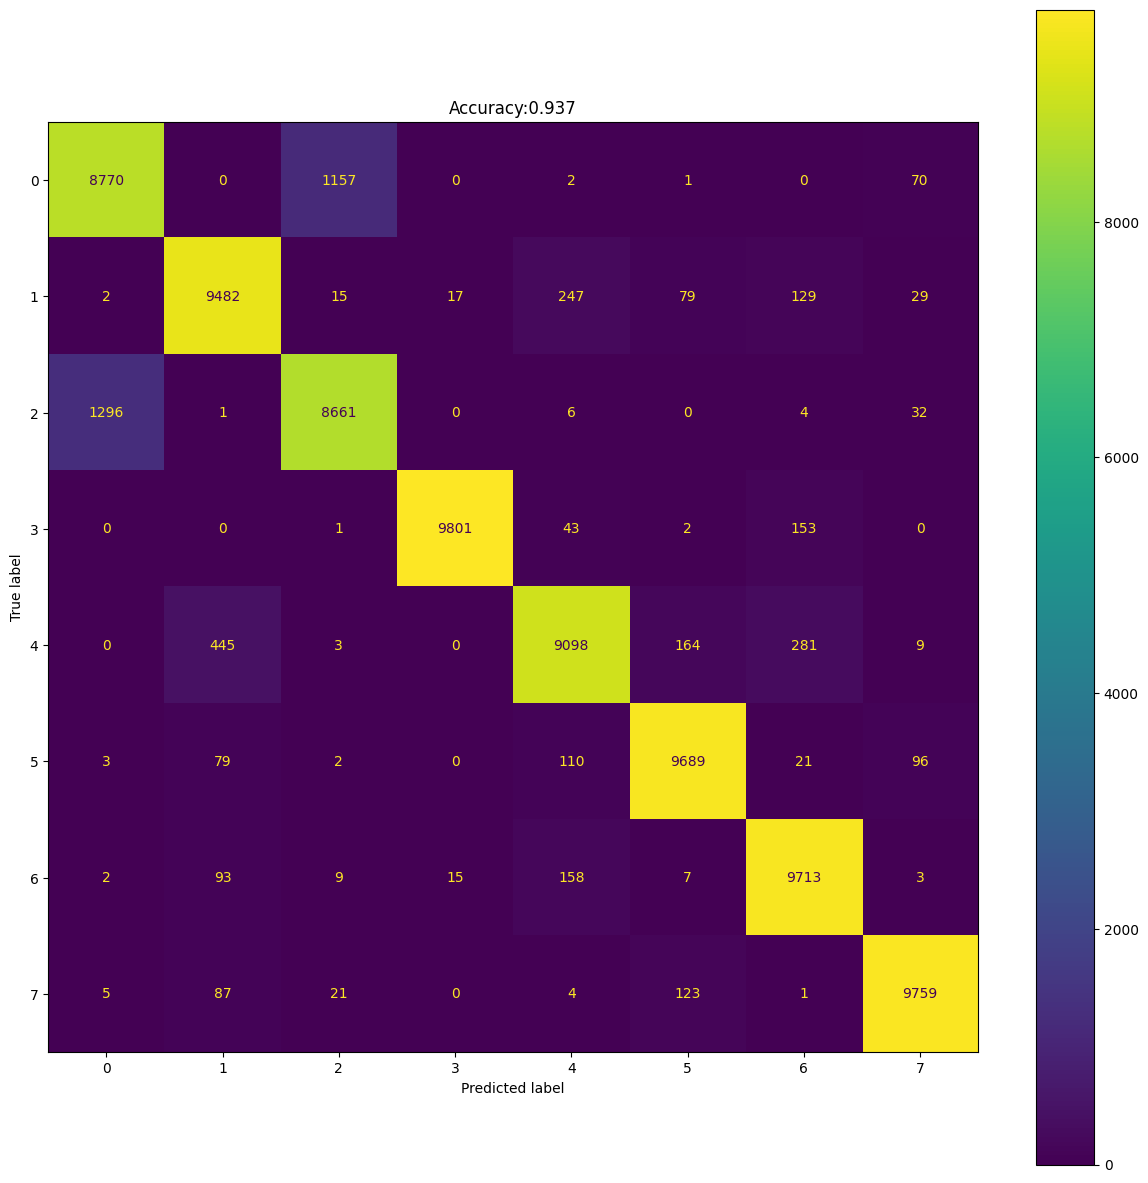

In [25]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-30(i) model to Nordic Device-25(iii) dataset 

In [26]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 31.4668 - accuracy: 0.1296
test loss, test acc: [31.466787338256836, 0.12958750128746033]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[7 4 4 ... 4 4 4]
7
[[   0   14    0    9 9975    0    1    1]
 [   5  336   13 1716 7773    0  156    1]
 [   0   12    0   12 9971    0    5    0]
 [4381    0 5426   71    1   63   55    3]
 [   1    6    1   35 9956    0    1    0]
 [   1   43   11  128 9765    0   52    0]
 [   6    0 9806  141   39    1    3    4]
 [   2   48    0   11 9923    0   15    1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.73      0.03      0.06     10000
           2       0.00      0.00      0.00     10000
           3       0.03      0.01      0.01     10000
           4       0.17      1.00      0.30     10000
           5       0.00      0.00      0.00     10000
           6       0.01      0.00      0.00     10000
           7       0.10      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.13      0.13  

Test Accuracy:0.1295875


Text(0.5, 1.0, 'Accuracy:0.130')

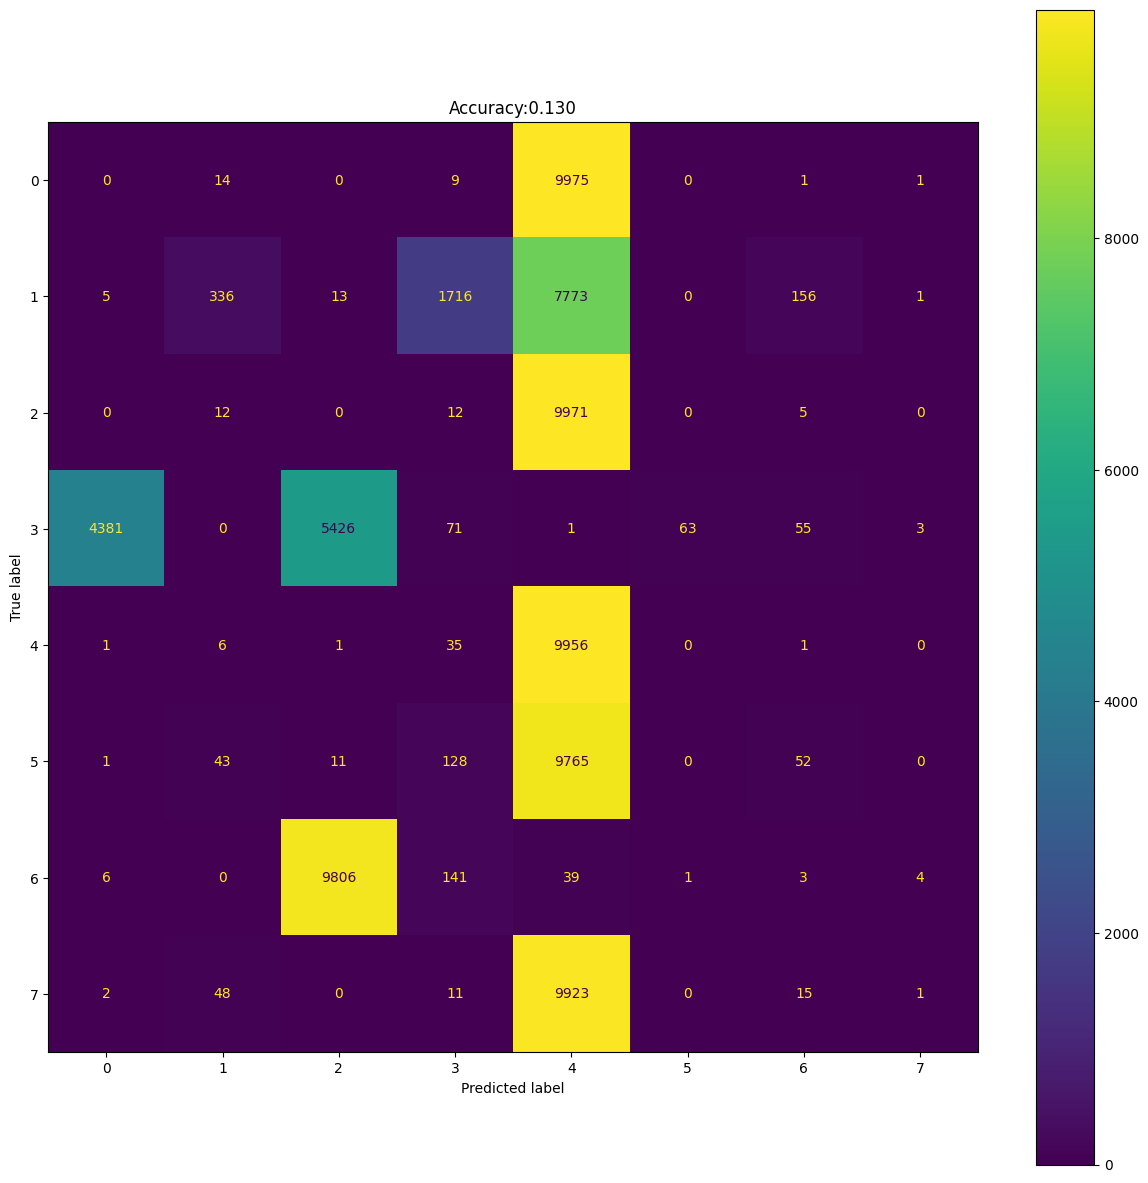

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [30]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [31]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [32]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 3.0851 - accuracy: 0.3320
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.0001 - accuracy: 0.6040
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8624 - accuracy: 0.6734
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7933 - accuracy: 0.7071
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7485 - accuracy: 0.7250
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7171 - accuracy: 0.7355
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6934 - accuracy: 0.7444
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6739 - accuracy: 0.7517
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6583 - accuracy: 0.7584
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

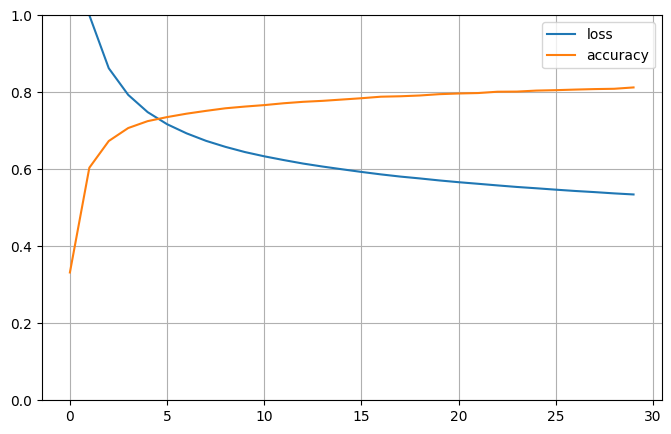

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [34]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.5334 - accuracy: 0.8132
test loss, test acc: [0.533362627029419, 0.813212513923645]


In [35]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[6 7 5 ... 5 7 5]
6
[[8481   12  719    2  555   14    2  215]
 [   0 9461    0   42   31  425    6   35]
 [3996   24 4799    3  831   12    2  333]
 [   0   42    0 9930    0    3   25    0]
 [   8   67  764    2 8803  113    5  238]
 [   4  364   13   16  248 8270   14 1071]
 [   0   13    1   53    3    7 9923    0]
 [   1  157   95    2  170 4183    2 5390]]
              precision    recall  f1-score   support

           0       0.68      0.85      0.75     10000
           1       0.93      0.95      0.94     10000
           2       0.75      0.48      0.59     10000
           3       0.99      0.99      0.99     10000
           4       0.83      0.88      0.85     10000
           5       0.63      0.83      0.72     10000
           6       0.99      0.99      0.99     10000
           7       0.74      0.54      0.62     10000

    accuracy                           0.81     80000
   macro avg       0.82      0.81  

Test Accuracy:0.8132125


Text(0.5, 1.0, 'Accuracy:0.813')

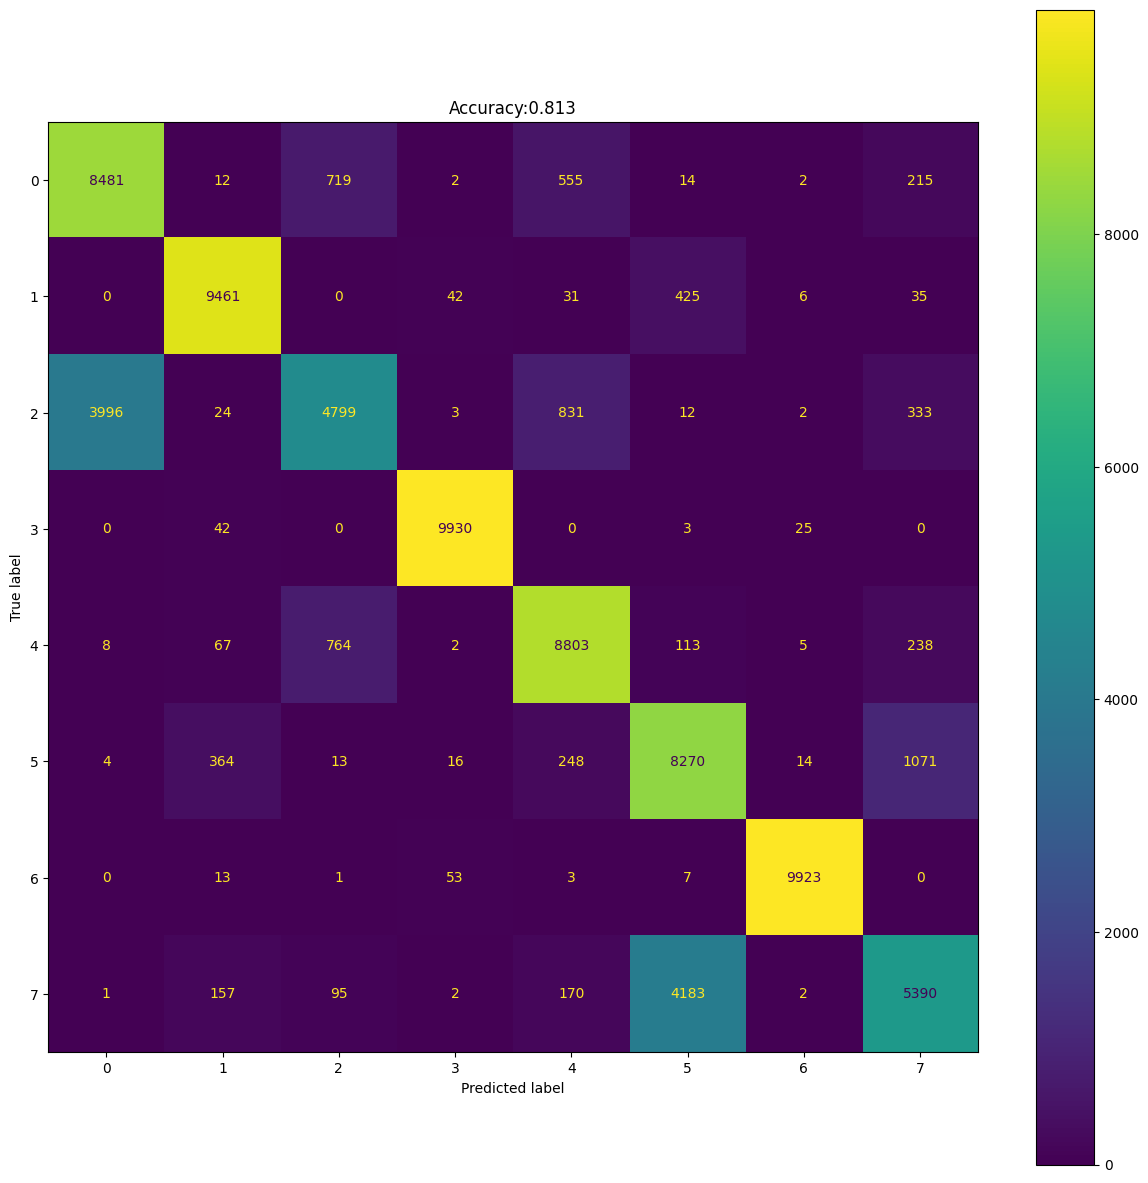

In [36]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(ii) model to Nordic Device-25(iii) dataset 

In [37]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

In [38]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 23.5474 - accuracy: 0.0025
test loss, test acc: [23.54741859436035, 0.0024625000078231096]


In [39]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 5ms/step
[5 1 1 ... 1 1 3]
5
[[   1 9848    1   68   79    3    0    0]
 [ 184  164    9 9587   27   26    3    0]
 [   4 9662    5   85  244    0    0    0]
 [  30    0 7605    0    0  173 2184    8]
 [  17   25    2 9954    1    0    1    0]
 [  90 3219    5 6633   27   24    2    0]
 [9686   20   10  227   36   18    0    3]
 [   6 9630    1  346   12    3    0    2]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.01      0.02      0.01     10000
           2       0.00      0.00      0.00     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.10      0.00      0.00     10000
           6       0.00      0.00      0.00     10000
           7       0.15      0.00      0.00     10000

    accuracy                           0.00     80000
   macro avg       0.03      0.00  

Test Accuracy:0.0024625


Text(0.5, 1.0, 'Accuracy:0.002')

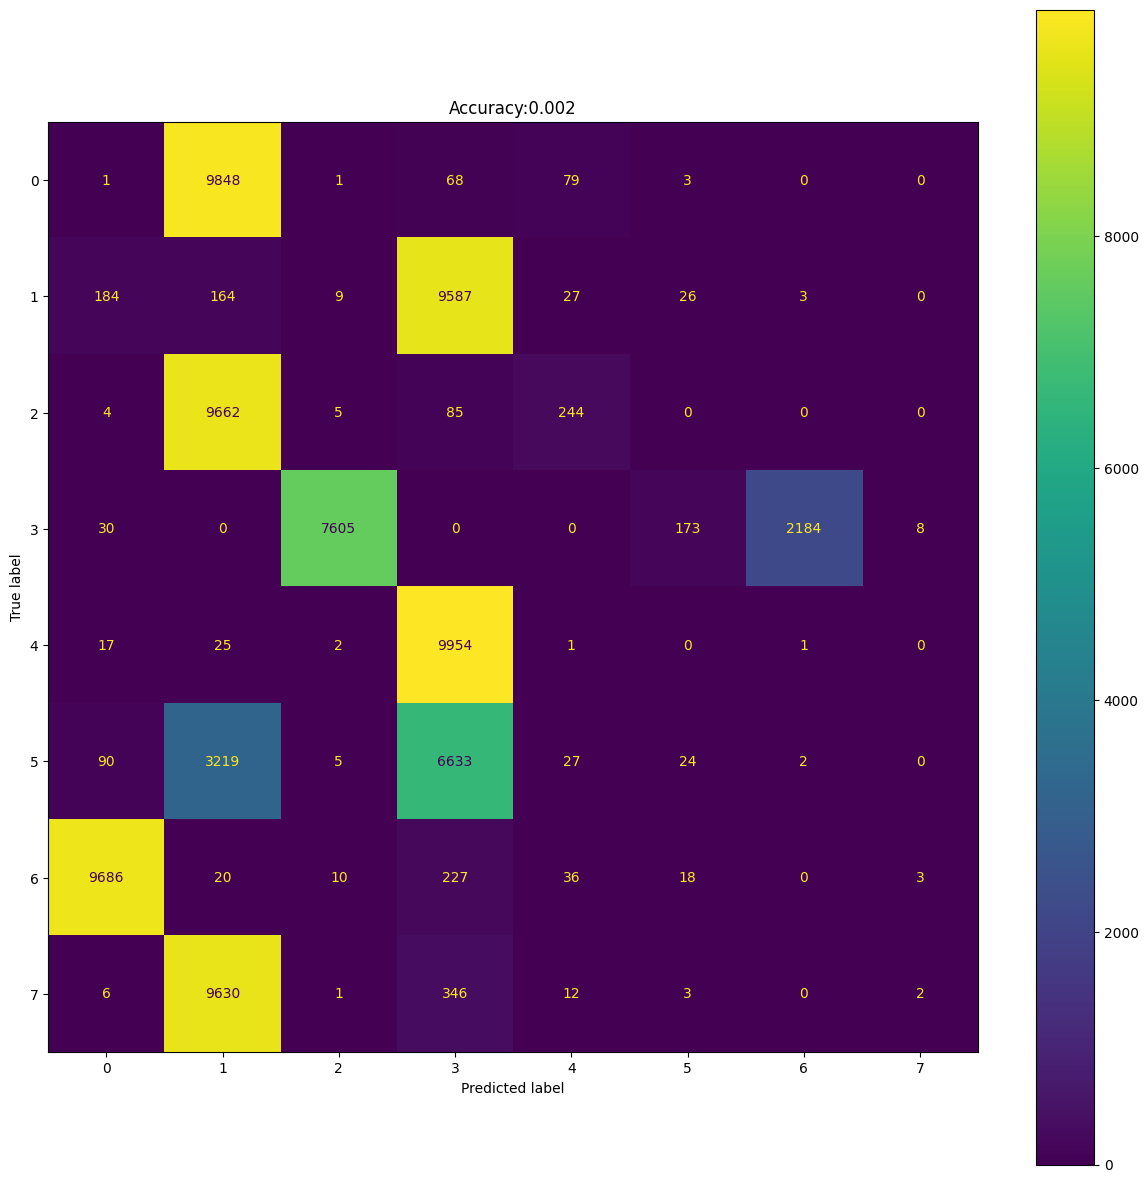

In [40]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [41]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [42]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [43]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.8809 - accuracy: 0.3285
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.7525 - accuracy: 0.7750
Epoch 3/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.5927 - accuracy: 0.8950
Epoch 4/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5199 - accuracy: 0.9182
Epoch 5/30
2500/2500 [==============================] - 11s 5ms/step - loss: 0.4744 - accuracy: 0.9257
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4430 - accuracy: 0.9298
Epoch 7/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.4196 - accuracy: 0.9321
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4014 - accuracy: 0.9337
Epoch 9/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3874 - accuracy: 0.9345
Epoch 10/30
2500/2500 [==============================] - 13s 5ms/step - l

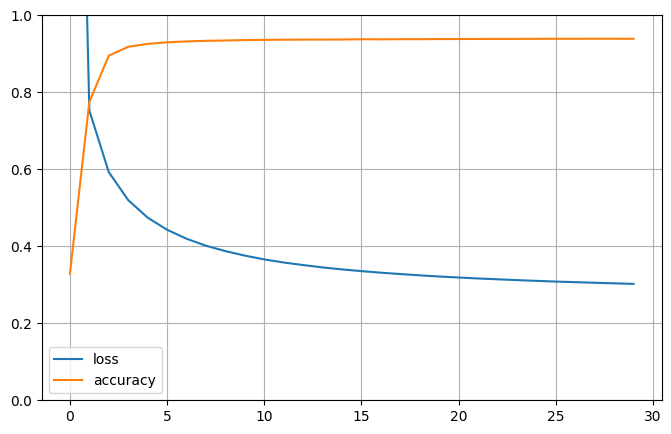

In [44]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [45]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.3016 - accuracy: 0.9406
test loss, test acc: [0.3015711307525635, 0.9405999779701233]


In [46]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[6 7 7 ... 7 7 7]
6
[[8223    1 1654    1   34   13    9   65]
 [   4 9589   15   25   26   63  173  105]
 [1182    0 8723    4   17    7   18   49]
 [   0    0    0 9963    0    0   37    0]
 [   6   42   32    5 9844   36   23   12]
 [   8  131   45   12   19 9476  125  184]
 [   0  112   27   24   10    0 9821    6]
 [   8   57   29    4   50  231   12 9609]]
              precision    recall  f1-score   support

           0       0.87      0.82      0.85     10000
           1       0.97      0.96      0.96     10000
           2       0.83      0.87      0.85     10000
           3       0.99      1.00      0.99     10000
           4       0.98      0.98      0.98     10000
           5       0.96      0.95      0.96     10000
           6       0.96      0.98      0.97     10000
           7       0.96      0.96      0.96     10000

    accuracy                           0.94     80000
   macro avg       0.94      0.94  

Test Accuracy:0.9406


Text(0.5, 1.0, 'Accuracy:0.941')

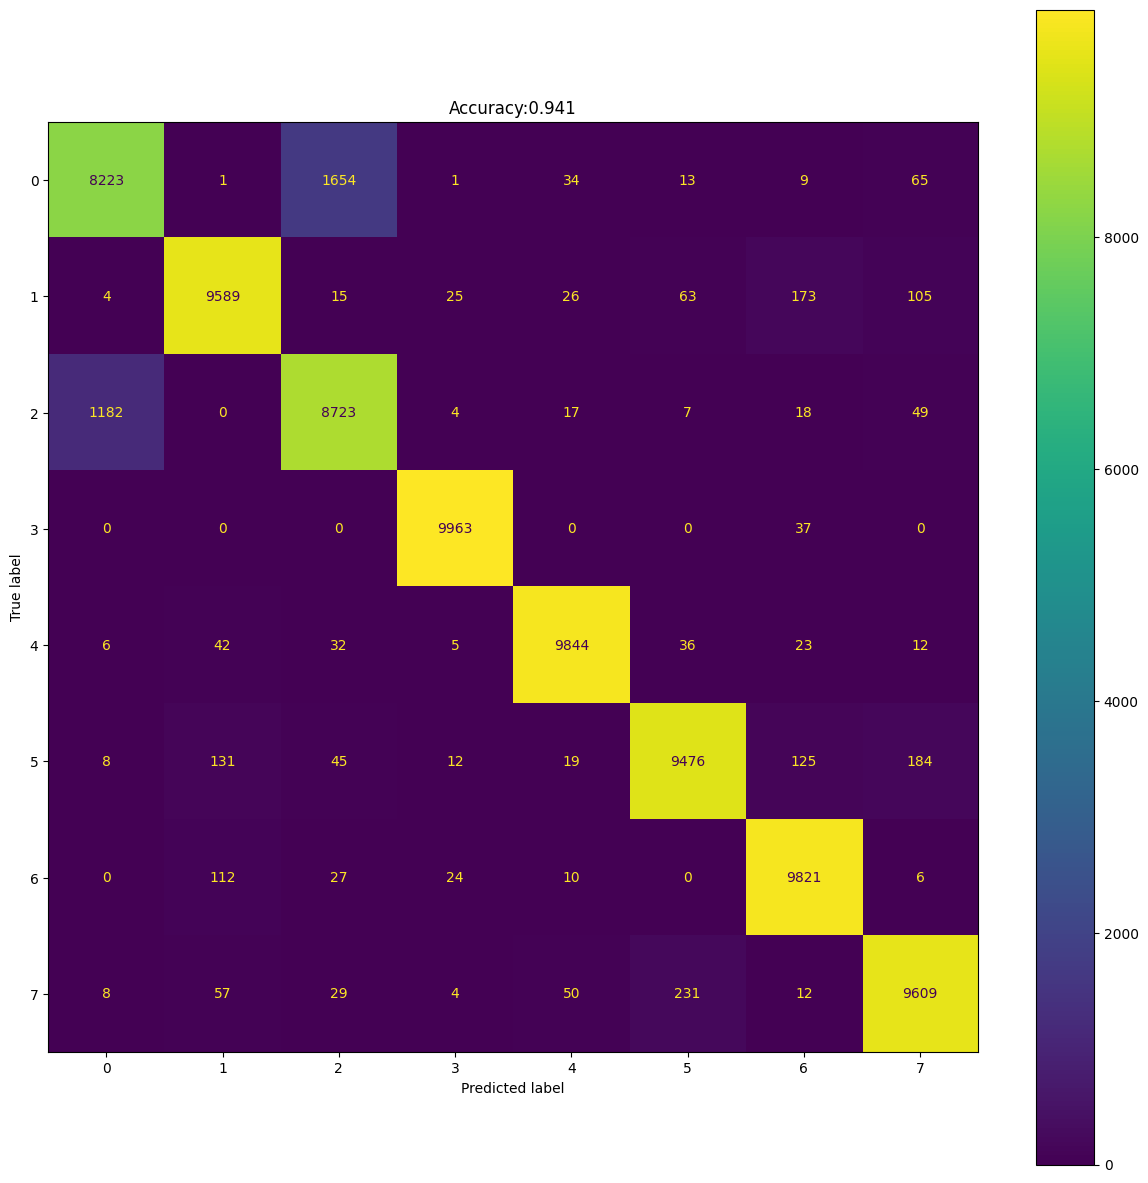

In [47]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-25(iii) dataset 

In [48]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [49]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 18.0736 - accuracy: 0.1090
test loss, test acc: [18.073598861694336, 0.1090250015258789]


In [50]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[5 1 1 ... 1 1 1]
5
[[ 145 9844    5    0    5    1    0    0]
 [   7 8554  299    3 1124   11    1    1]
 [3106 6870   11    5    5    2    1    0]
 [   0    0    7    7   24 7176 1380 1406]
 [9923    9   43   23    1    1    0    0]
 [  38 9849   43    3   65    1    1    0]
 [  15   35 9587    5  329   23    3    3]
 [  10 9970    2    1   14    1    2    0]]
              precision    recall  f1-score   support

           0       0.01      0.01      0.01     10000
           1       0.19      0.86      0.31     10000
           2       0.00      0.00      0.00     10000
           3       0.15      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.00      0.00      0.00     10000
           6       0.00      0.00      0.00     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.11     80000
   macro avg       0.04      0.11  

Test Accuracy:0.109025


Text(0.5, 1.0, 'Accuracy:0.109')

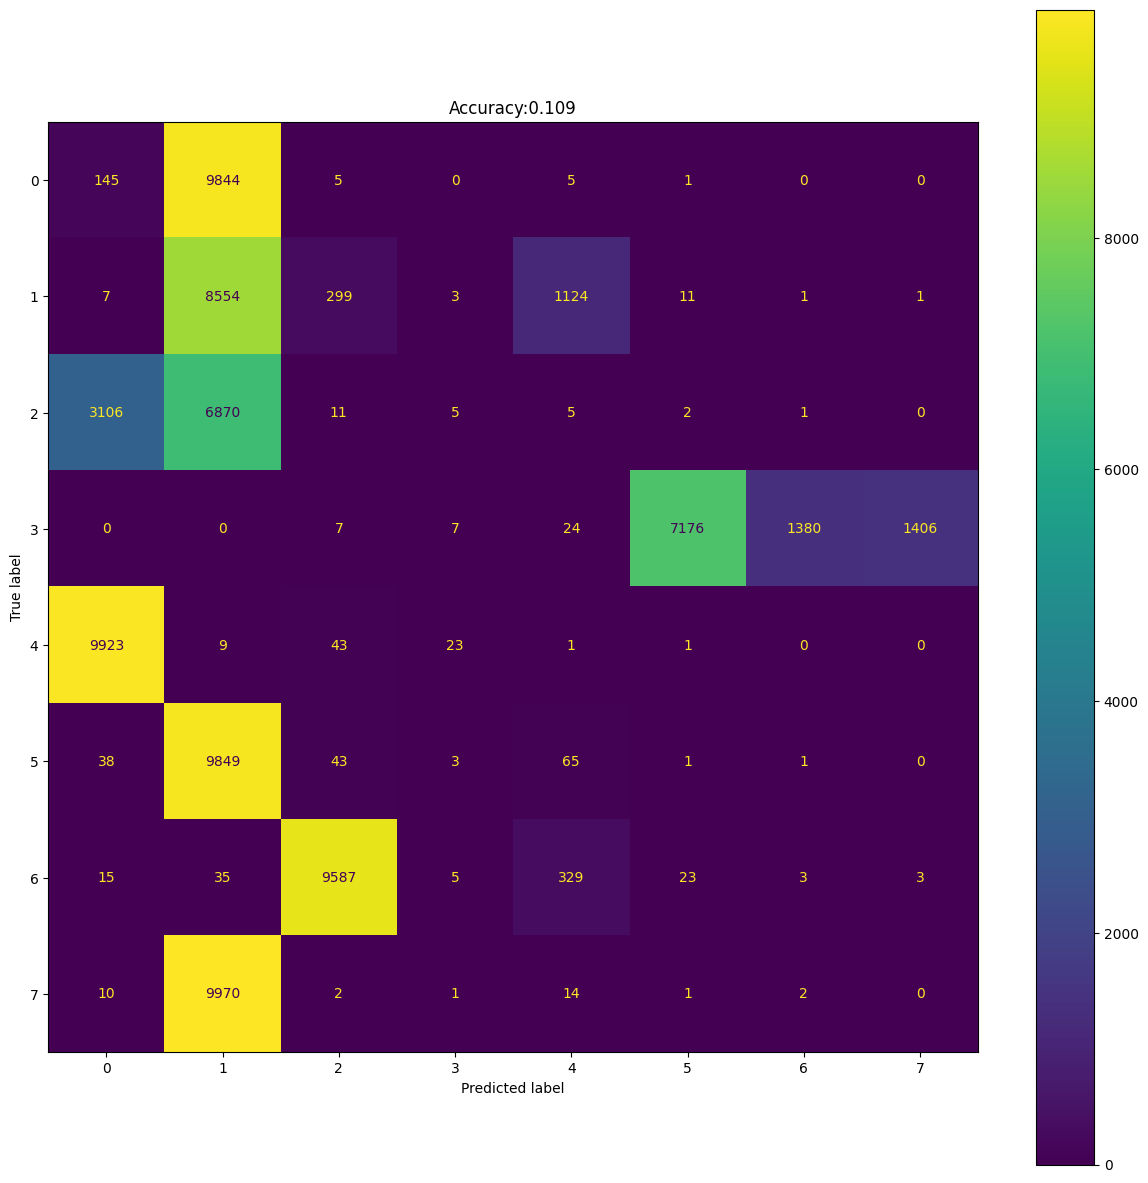

In [51]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [52]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [53]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [54]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.4985 - accuracy: 0.4502
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6708 - accuracy: 0.8053
Epoch 3/30
2500/2500 [==============================] - 15s 6ms/step - loss: 0.5494 - accuracy: 0.8755
Epoch 4/30
2500/2500 [==============================] - 14s 5ms/step - loss: 0.5011 - accuracy: 0.8881
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4710 - accuracy: 0.8938
Epoch 6/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.4488 - accuracy: 0.8983
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4318 - accuracy: 0.9013
Epoch 8/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.4182 - accuracy: 0.9033
Epoch 9/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.4071 - accuracy: 0.9046
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

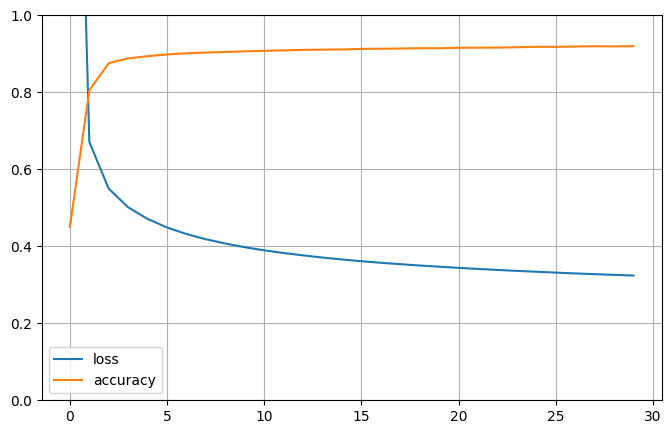

In [55]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [56]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.3226 - accuracy: 0.9204
test loss, test acc: [0.3225556015968323, 0.9203624725341797]


In [57]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[3 5 5 ... 7 7 7]
3
[[9441    7  346    1    4   27    4  170]
 [   3 9443    5    8    8   82   94  357]
 [ 730   18 8307    4  198  527   13  203]
 [   0    8    0 9949    0    0   43    0]
 [   2    3  165    1 9789    0   40    0]
 [  48  147  246    1    9 8383   73 1093]
 [   2  106    9    7   19    3 9844   10]
 [   6  293   26    2    7 1190    3 8473]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10000
           1       0.94      0.94      0.94     10000
           2       0.91      0.83      0.87     10000
           3       1.00      0.99      1.00     10000
           4       0.98      0.98      0.98     10000
           5       0.82      0.84      0.83     10000
           6       0.97      0.98      0.98     10000
           7       0.82      0.85      0.83     10000

    accuracy                           0.92     80000
   macro avg       0.92      0.92  

Test Accuracy:0.9203625


Text(0.5, 1.0, 'Accuracy:0.920')

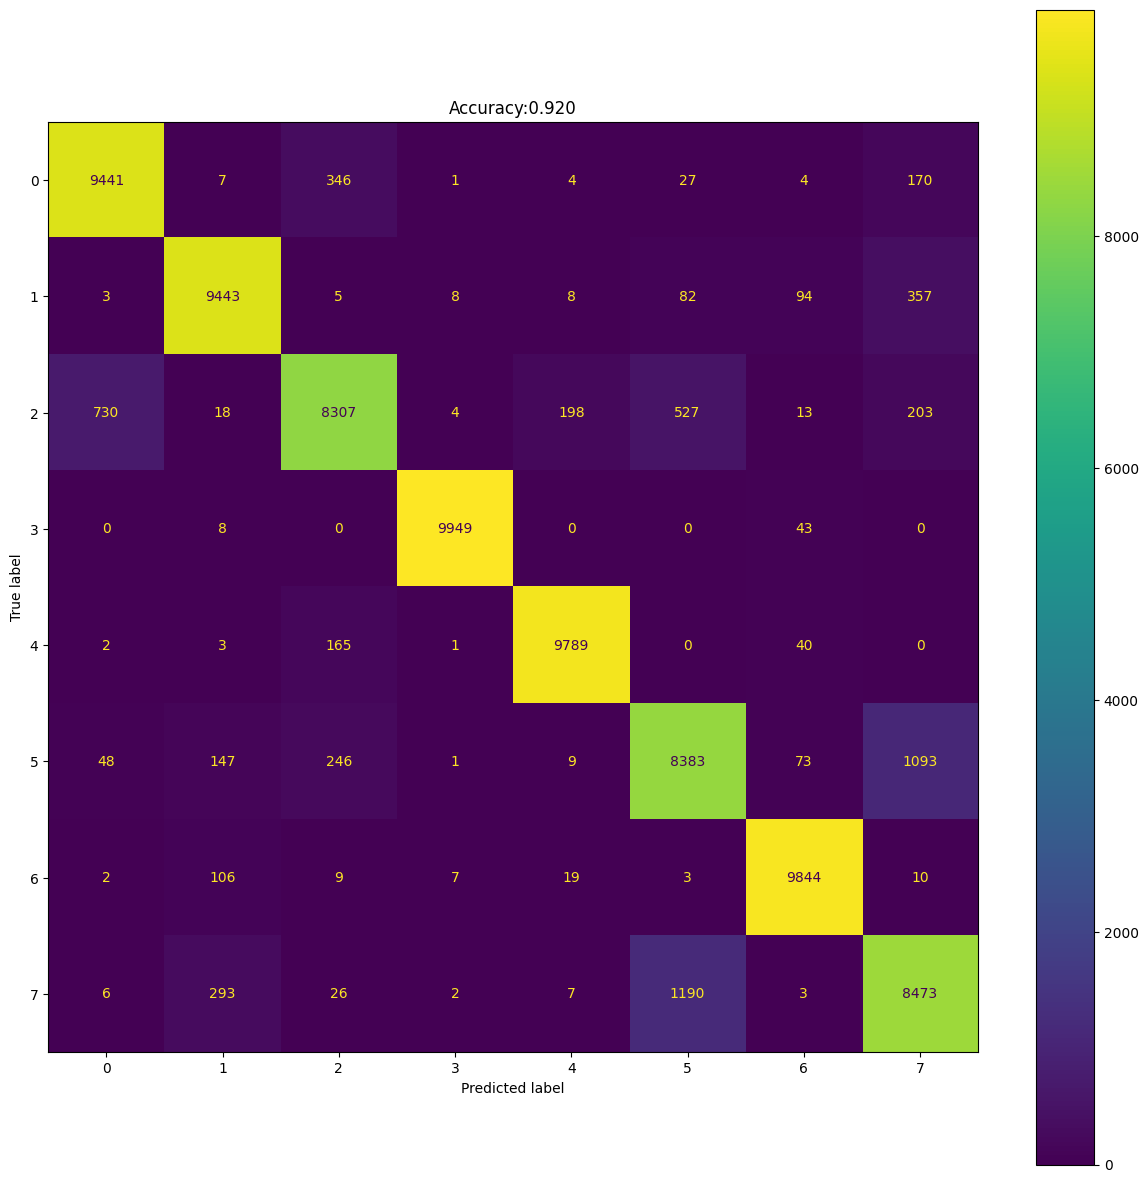

In [58]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')